In [2]:
use_gpu = False

In [11]:
import numpy as np
import pickle
import pandas as pd
from tqdm import tqdm

import os
import sys
sys.path.insert(0, '..')

if use_gpu:
    from utils.gpu_tools import *
    os.environ["CUDA_VISIBLE_DEVICES"] = ','.join([ str(obj) for obj in select_gpu(query_gpu())])

os.environ["CUDA_LAUNCH_BLOCKING"] = '1'

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

torch.manual_seed(42)

IMAGE_WIDTH = {5: 15, 16:64, 20: 60, 60: 180}
IMAGE_HEIGHT = {5: 32, 16:48, 20: 64, 60: 96}  


## load data

In [19]:
raw_images = []
raw_label_df = []
raw_images = pickle.load(open('../crypto/data/240_16_8_images.dat', 'rb'))
raw_label_df = pd.read_feather('../crypto/data/240_16_8_labels.feather')
raw_images = np.array(raw_images).reshape((-1, IMAGE_HEIGHT[16], IMAGE_WIDTH[16]))



print(raw_images.shape)
print(raw_label_df.shape)

(124843, 48, 64)
(124843, 7)


In [53]:
# Calculate the index for 80% of the data
split_index = int(0.8 * len(raw_images))

# Split the images
images = raw_images[split_index:]
label_df = raw_label_df.iloc[split_index:]
# label_df.to_csv('test.csv')
# Split the labels
print(images.shape)
print(label_df.shape)
print(label_df.head())

(24969, 48, 64)
(24969, 7)
      Asset          Start_Date            End_Date  Daily_Return   Ret_24H  \
11838  ARPA 2023-04-25 14:00:00 2023-04-26 13:00:00      0.045466  0.070434   
73379  MASK 2023-04-25 14:00:00 2023-04-26 13:00:00      0.008035  0.052946   
79343    MV 2023-04-25 14:00:00 2023-04-26 13:00:00     -0.004003 -0.005604   
62091   KEY 2023-04-25 14:00:00 2023-04-26 13:00:00      0.024100  0.052418   
32410   CRV 2023-04-25 14:00:00 2023-04-26 13:00:00      0.034444  0.077778   

         Ret_8H    Market_Cap  
11838  0.023755  3.869844e+07  
73379  0.052271  3.419027e+08  
79343 -0.007968  1.126955e+07  
62091  0.032552  4.064087e+07  
32410  0.037311  7.489409e+08  


## build dataset

In [33]:
from torch.utils.data import Dataset
import torch

class MyDataset(Dataset):
    
    def __init__(self, img, label):
        self.img = torch.Tensor(img.copy())
        self.label = torch.Tensor(label)
        self.len = len(img)

        # Ensure the image tensor is in the shape [batch, height, width]
        if len(self.img.shape) == 3:
            # Add a channel dimension: [batch, 1, height, width]
            self.img = self.img.unsqueeze(1)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.img[idx], self.label[idx]


In [34]:
dataset = MyDataset(images, (label_df.Ret_24H > 0).values)

In [37]:
test_dataloader = DataLoader(dataset, batch_size=2048, shuffle=False)
# dataiter = iter(test_dataloader)
# images, labels = dataiter.__next__()  # Use __next__() instead of next()

# # Print the shape of the images and labels in the batch
# print("Shape of images in batch:", images.shape)
# print("Shape of labels in batch:", labels.shape)


# the neural network

In [38]:
net_path = '../pt/20231121_230235/baseline_epoch_6_train_0.547636_val_0.161804.pt'

In [39]:
from models import baseline
device = 'cuda' if use_gpu else 'cpu'

In [40]:
net = torch.load(net_path)


## test

In [41]:
def eval_loop(dataloader, net, loss_fn):
    
    running_loss = 0.0
    total_loss = 0.0
    current = 0
    net.eval()
    target = []
    predict = []
    with torch.no_grad():
        with tqdm(dataloader) as t:
            for batch, (X, y) in enumerate(t):
                X = X.to(device)
                y = y.to(device)
                y_pred = net(X)
                target.append(y.detach())
                predict.append(y_pred.detach())
                loss = loss_fn(y_pred, y.long())
                
                running_loss = (len(X) * loss.item() + running_loss * current) / (len(X) + current)
                current += len(X)
                t.set_postfix({'running_loss':running_loss})
            
    return total_loss, torch.cat(predict), torch.cat(target)

In [42]:
loss_fn = nn.CrossEntropyLoss()
test_loss, y_pred, y_target = eval_loop(test_dataloader, net, loss_fn)

predict_logit = (torch.nn.Softmax(dim=1)(y_pred)[:,1]).cpu().numpy()

100%|██████████| 13/13 [01:01<00:00,  4.77s/it, running_loss=0.534]


## Plot the performance

In [45]:
from matplotlib import pyplot as plt

       Asset          Start_Date            End_Date  Daily_Return   Ret_24H  \
11838   ARPA 2023-04-25 14:00:00 2023-04-26 13:00:00      0.045466  0.070434   
73379   MASK 2023-04-25 14:00:00 2023-04-26 13:00:00      0.008035  0.052946   
79343     MV 2023-04-25 14:00:00 2023-04-26 13:00:00     -0.004003 -0.005604   
62091    KEY 2023-04-25 14:00:00 2023-04-26 13:00:00      0.024100  0.052418   
32410    CRV 2023-04-25 14:00:00 2023-04-26 13:00:00      0.034444  0.077778   
...      ...                 ...                 ...           ...       ...   
2382     ACA 2023-09-29 19:00:00 2023-09-30 18:00:00     -0.020408  0.000000   
100878   SGB 2023-09-29 19:00:00 2023-09-30 18:00:00      0.000000  0.000000   
57870   INTR 2023-09-29 20:00:00 2023-09-30 19:00:00      0.150538  0.333333   
53504    GRT 2023-09-29 21:00:00 2023-09-30 20:00:00      0.010203  0.018228   
88887   PAXG 2023-09-29 22:00:00 2023-09-30 21:00:00      0.000864  0.002060   

          Ret_8H    Market_Cap       re

### Same Weighted

In [46]:
threshold = 0.

label_df['ret'] = (predict_logit>threshold) * label_df.Ret_24H
label_filtered = label_df[predict_logit>threshold]
ret_baseline = label_filtered .groupby(['Start_Date'])['Ret_24H'].mean()

threshold = 0.58

label_df['ret'] = (predict_logit>threshold) * label_df.Ret_24H
label_filtered = label_df[predict_logit>threshold]
ret_cnn = label_filtered .groupby(['Start_Date'])['Ret_24H'].mean()


C:\Users\shoge\AppData\Local\Temp\ipykernel_25072\1521685346.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_df['ret'] = (predict_logit>threshold) * label_df.Ret_24H
C:\Users\shoge\AppData\Local\Temp\ipykernel_25072\1521685346.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_df['ret'] = (predict_logit>threshold) * label_df.Ret_24H


#### number of stocks selected by time

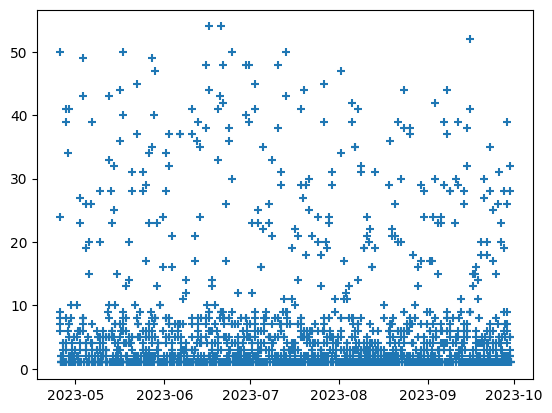

In [47]:
plt.scatter(label_filtered.groupby(['Start_Date'])['ret'].count().index, label_filtered.groupby(['Start_Date'])['ret'].count(),marker='+')

### Compare of log accumulate return

C:\Users\shoge\AppData\Local\Temp\ipykernel_25072\1188020696.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  log_ret_baseline = np.log10((ret_baseline+1).cumprod().fillna(method='ffill'))
C:\Users\shoge\AppData\Local\Temp\ipykernel_25072\1188020696.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  log_ret_cnn = np.log10((ret_cnn+1).cumprod().fillna(method='ffill'))


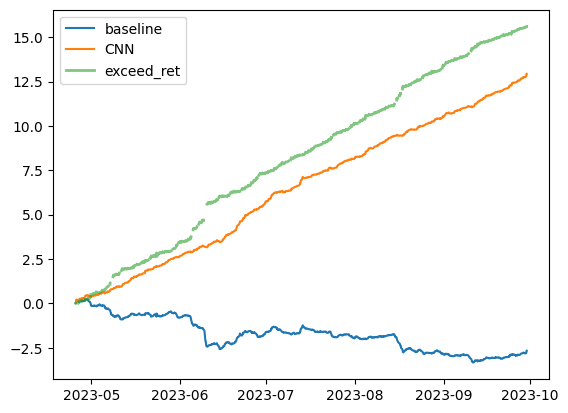

In [48]:
log_ret_baseline = np.log10((ret_baseline+1).cumprod().fillna(method='ffill'))
log_ret_cnn = np.log10((ret_cnn+1).cumprod().fillna(method='ffill'))
fig = plt.figure()
plt.plot(log_ret_baseline, label='baseline')
plt.plot(log_ret_cnn, label='CNN')
plt.plot(log_ret_cnn - log_ret_baseline, alpha=0.6, lw=2, label='exceed_ret')
plt.legend()
plt.show()
fig.savefig('../pic/performance1.png',dpi=300)


In [49]:
import pandas as pd
import numpy as np

def analyze_performance(return_streams):
    results = {}

    for strategy, returns in return_streams.items():
        # Ensure the returns are a Pandas Series
        if not isinstance(returns, pd.Series):
            returns = pd.Series(returns)

        # Calculations
        # Sharpe Ratio
        sharpe_ratio = returns.mean() / returns.std()

        # Max Drawdown
        rolling_max = returns.cummax()
        drawdown = (returns - rolling_max) / rolling_max
        max_drawdown = drawdown.min()

        # Sortino Ratio
        target_return = 0
        downside_returns = returns[returns < target_return]
        sortino_ratio = (returns.mean() - target_return) / downside_returns.std()

        # Turnover (Assuming we need additional data like portfolio holdings)
        # turnover = ... (This metric typically requires holdings data)

        # Additional Metrics (like Alpha, Beta, Annualized Return, Volatility)
        # Assuming a risk-free rate of 0 for simplicity
        annualized_return = (1 + returns.mean()) ** 252 - 1  # 252 trading days
        volatility = returns.std() * np.sqrt(252)

        # Compile the results
        results[strategy] = {
            "Sharpe Ratio": sharpe_ratio,
            "Max Drawdown": max_drawdown,
            "Sortino Ratio": sortino_ratio,
            "Annualized Return": annualized_return,
            "Volatility": volatility
        }

    return pd.DataFrame(results)

# Example usage
return_streams = {
    "CNN 1": ret_cnn,  # Replace with actual returns
    "Baseline 2": ret_baseline   # Replace with actual returns
}

analyze_performance(return_streams)


,CNN 1,Baseline 2
Sharpe Ratio,0.569806,-0.057232
Max Drawdown,-1.514934,-2.115111
Sortino Ratio,1.121471,-0.078242
Annualized Return,84.096295,-0.381661
Volatility,0.495633,0.528608


C:\Users\shoge\AppData\Local\Temp\ipykernel_25072\3359981319.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  plt.plot((ret_cnn+1).cumprod().fillna(method='ffill'), label='CNN_accumulate_ret')


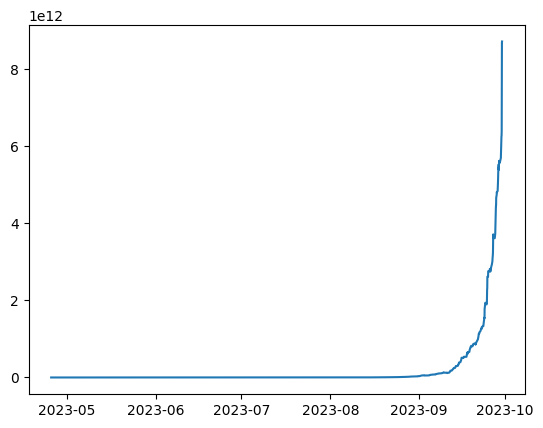

In [50]:
plt.plot((ret_cnn+1).cumprod().fillna(method='ffill'), label='CNN_accumulate_ret')
plt.savefig('../pic/performance2.png',dpi=300)

## Weighted by EWMA_Vol

In [51]:
label_df['weighted_ret'] = 1 * label_df.Ret_20d * label_df['EWMA_vol']
label_df['weight'] = 1 * label_df['EWMA_vol']
ret_baseline = label_df.groupby(['Date'])['weighted_ret'].sum()/(label_df.groupby(['Date'])['weight'].sum())

threshold = 0.58

label_df['weighted_ret'] = (predict_logit>threshold) * label_df.Ret_20d * label_df['EWMA_vol']
label_df['weight'] = (predict_logit>threshold) * label_df['EWMA_vol']
ret_cnn = label_df.groupby(['Date'])['weighted_ret'].sum()/(label_df.groupby(['Date'])['weight'].sum())

AttributeError: 'DataFrame' object has no attribute 'Ret_20d'

C:\Users\shoge\AppData\Local\Temp\ipykernel_25072\3543503651.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  log_ret_baseline = np.log10((ret_baseline+1).cumprod().fillna(method='ffill'))
C:\Users\shoge\AppData\Local\Temp\ipykernel_25072\3543503651.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  log_ret_cnn = np.log10((ret_cnn+1).cumprod().fillna(method='ffill'))


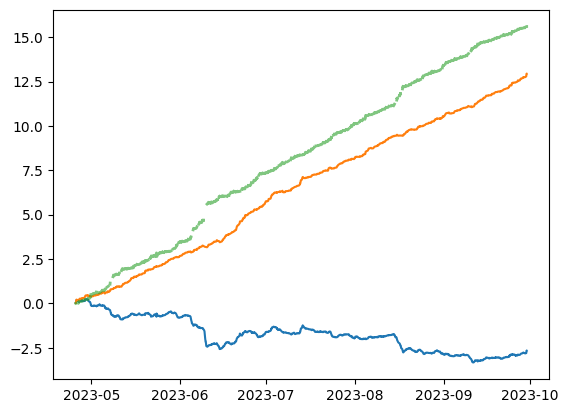

In [52]:
log_ret_baseline = np.log10((ret_baseline+1).cumprod().fillna(method='ffill'))
log_ret_cnn = np.log10((ret_cnn+1).cumprod().fillna(method='ffill'))
plt.plot(log_ret_baseline)
plt.plot(log_ret_cnn)
plt.plot(log_ret_cnn - log_ret_baseline, alpha=0.6, lw=2)